In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Exemplo Clusterização

In [4]:
df = pd.read_csv('../data/data.csv',encoding='latin-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
x = (
    df
    .loc[~df.InvoiceNo.str.startswith('C'),:]
    .assign(total = lambda x: x.Quantity * x.UnitPrice)
    .groupby('CustomerID')
    .agg({'total':np.mean,'Quantity':np.mean})
)

x

,total,Quantity
CustomerID,,
12346.0,77183.600000,74215.000000
12347.0,23.681319,13.505495
12348.0,57.975484,75.516129
12349.0,24.076027,8.643836
12350.0,19.670588,11.588235
...,...,...
18280.0,18.060000,4.500000
18281.0,11.545714,7.714286
18282.0,14.837500,8.583333


In [6]:
def find_outlier(coluna,peso=1.5):
    
    iqr = np.percentile(coluna,75) - np.percentile(coluna,25)
    limite_inferior = np.percentile(coluna,25) - (peso*iqr)
    limite_superior = np.percentile(coluna,75) + (peso*iqr)
    
    return (coluna > limite_superior) | (coluna < limite_inferior)

In [7]:
x_no_out = (
    x
    .assign(out_Quantity = lambda x: x.Quantity.pipe(find_outlier))
    .assign(out_total  = lambda x: x.total.pipe(find_outlier))
    .query("out_Quantity == False and out_total == False")
    .drop(['out_Quantity','out_total'],axis=1)
)

In [8]:
scaler = StandardScaler().fit(x_no_out)
x_scaled = scaler.transform(x_no_out)

In [22]:
km = KMeans(n_clusters=6,random_state=42)
km.fit(x_scaled)

KMeans(n_clusters=6, random_state=42)

In [23]:
x_no_out = x_no_out.assign(grupo = km.labels_)

In [24]:
x_no_out.grupo.value_counts()

3    1025
0     985
4     832
1     415
2     310
5     173
Name: grupo, dtype: int64

<AxesSubplot:xlabel='grupo', ylabel='count'>

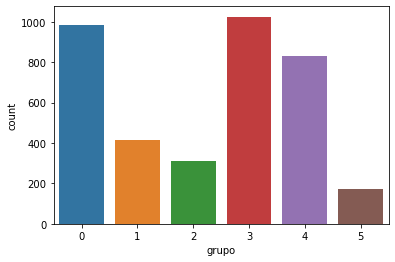

In [25]:
sns.countplot(x='grupo',data=x_no_out)

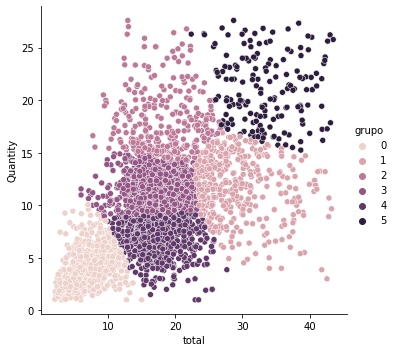

In [26]:
sns.relplot(x='total',y='Quantity',hue='grupo',data=x_no_out)

In [27]:
pd.DataFrame(scaler.inverse_transform(km.cluster_centers_)).style.highlight_max(axis=0).highlight_min(axis=0)

,0,1
0,6.685293,3.781169
1,28.856780,11.767388
2,18.307126,17.853905
3,17.184298,11.284357
4,17.680893,7.112514
5,33.420194,21.025518


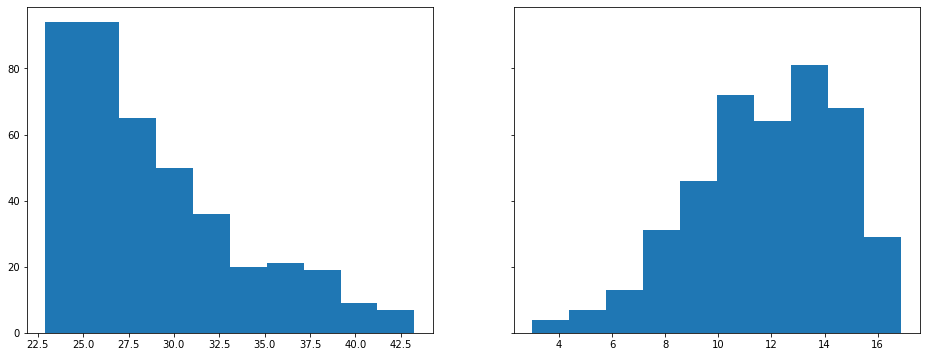

In [35]:
f , ax = plt.subplots(1,2,sharey=True,figsize=(16,6))


ax[0].hist(x_no_out.query('grupo == 1').total)
ax[1].hist(x_no_out.query('grupo == 1').Quantity)

plt.show()

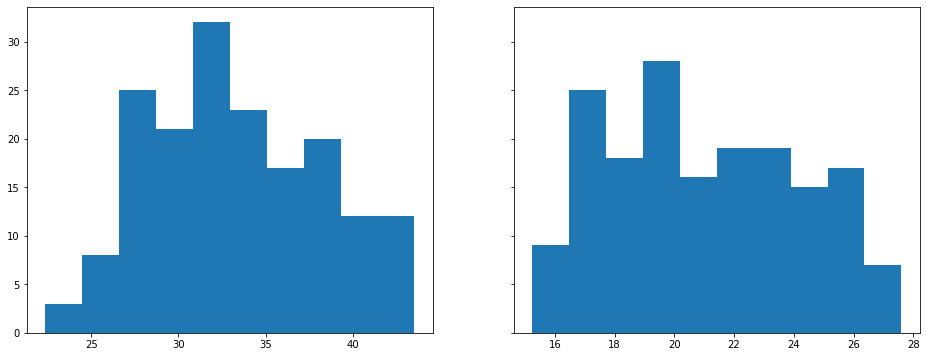

In [36]:
f , ax = plt.subplots(1,2,sharey=True,figsize=(16,6))


ax[0].hist(x_no_out.query('grupo == 5').total)
ax[1].hist(x_no_out.query('grupo == 5').Quantity)

plt.show()